# Training

---
# 📦 Section 1: Setup & Configuration

First, let's set up our environment and create a shared configuration system that allows us to easily compare different models and training strategies.

In [18]:
# Essential imports for deep learning and visualization
import os
import time
import random
import sys
import json
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple
from dataclasses import dataclass, field, asdict

from datetime import datetime

# Scientific computing and visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import cv2
from PIL import Image

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

# HuggingFace Transformers for SegFormer
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

DATA_ROOT = "./datasets/NYUDepthv2"

COLAB = 'google.colab' in sys.modules
if COLAB:
    assert torch.cuda.is_available(), "Colab session must have a GPU enabled."
    
    from google.colab import drive
    drive.mount('/content/drive')

    DATA_ROOT = "drive/MyDrive/EGH444/datasets/NYUDepthv2"

## 🎛️ Shared Configuration System

Let's create a comprehensive configuration system that allows us to easily switch between different experimental setups. This approach ensures reproducibility and makes it easy to compare different models.

In [19]:
@dataclass
class TrainingHistory:
    """Tracks comprehensive training metrics for analysis and visualization."""
    
    # Training metrics (per epoch)
    train_loss: List[float] = field(default_factory=list)
    train_miou: List[float] = field(default_factory=list)
    train_pixacc: List[float] = field(default_factory=list)
    
    # Validation metrics (per epoch)
    val_loss: List[float] = field(default_factory=list)
    val_miou: List[float] = field(default_factory=list)
    val_pixacc: List[float] = field(default_factory=list)
    val_iou_per_class: List[List[float]] = field(default_factory=list)
    
    # Training metadata
    learning_rates: List[float] = field(default_factory=list)
    epoch_times: List[float] = field(default_factory=list)
    
    def add_epoch(self, epoch_data: Dict[str, float]) -> None:
        """Add metrics for a completed epoch."""
        self.train_loss.append(epoch_data.get("train_loss", 0.0))
        self.train_miou.append(epoch_data.get("train_miou", 0.0))
        self.train_pixacc.append(epoch_data.get("train_pixacc", 0.0))
        
        self.val_loss.append(epoch_data.get("val_loss", 0.0))
        self.val_miou.append(epoch_data.get("val_miou", 0.0))
        self.val_pixacc.append(epoch_data.get("val_pixacc", 0.0))
        self.val_iou_per_class.append(epoch_data.get("val_iou_per_class", []))
        
        self.learning_rates.append(epoch_data.get("learning_rate", 0.0))
        self.epoch_times.append(epoch_data.get("epoch_time", 0.0))
    
    def get_best_epoch(self, metric: str = "val_miou") -> Tuple[int, float]:
        """Get the epoch number and value of the best performance."""
        values = getattr(self, metric, [])
        if not values:
            return 0, 0.0
        best_idx = max(range(len(values)), key=lambda i: values[i])
        return best_idx + 1, values[best_idx]  # 1-indexed epoch
    
    def __len__(self) -> int:
        """Return number of completed epochs."""
        return len(self.train_loss)


@dataclass
class TrainingConfig:
    """Self-contained training configuration that includes data setup."""
    
    model_name: str  # Simple model identifier for checkpoint organization
    epochs: int
    batch_size: int = 32
    
    processor: Optional[Any] = None  # SegFormer processor or similar (optional for custom datasets)
    data_root: str = DATA_ROOT
    image_size: Tuple[int, int] = (240, 320)  # (height, width)
    num_workers: int = 0
    pin_memory: bool = True
    
    learning_rate: float = 1e-4
    
    num_classes: int = 40
    ignore_index: int = 255
    device: str = "auto"
    seed: int = 42
    
    # Logging/checkpointing
    log_every: int = 1
    save_dir: str = "checkpoints"
    
    @property
    def model_dir(self) -> Path:
        """Get model-specific directory."""
        return Path(self.save_dir) / self.model_name
    
    def __post_init__(self):
        """Create save directory after initialization."""
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)
        Path(self.model_dir).mkdir(parents=True, exist_ok=True)
    

print("✅ Configuration classes defined!")

✅ Configuration classes defined!


## ⚙️ Device Setup & Seed Management

Proper device detection and seed management are crucial for reproducible experiments.

---
# 📂 Section 2: Data Loading & Transformations

NYUv2 dataset loading with SegFormer-compatible preprocessing and data augmentation.

In [20]:
def visualize_batch(batch: Dict[str, torch.Tensor], processor: SegformerImageProcessor, 
                    num_samples: int = 4) -> None:
    """Visualize samples from a batch."""
    
    # Convert SegFormer tensors back to images for visualization
    def denormalize_segformer(tensor: torch.Tensor) -> np.ndarray:
        """Denormalize SegFormer preprocessed image."""
        # SegFormer uses ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        img = tensor.permute(1, 2, 0).cpu().numpy()
        img = (img * std + mean).clip(0, 1)
        return (img * 255).astype(np.uint8)
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        # Simple colormap for visualization
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)  # 40 classes + ignore
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        
        return colored
    
    # Create visualization
    pixel_values = batch["pixel_values"]
    labels = batch["labels"] 
    ids = batch["id"]
    
    num_samples = min(num_samples, pixel_values.shape[0])
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_samples):
        # Denormalize image
        img = denormalize_segformer(pixel_values[i])
        mask = labels[i].cpu().numpy()
        colored_mask = colorize_mask(mask)
        
        # Plot image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Image: {ids[i]}")
        axes[0, i].axis("off")
        
        # Plot mask
        axes[1, i].imshow(colored_mask)
        axes[1, i].set_title(f"Mask: {mask.shape}")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [21]:
def to_nyu40_ids(mask_np: np.ndarray) -> np.ndarray:
    """Ensure mask uses NYUv2-40 label space [0..39]. Out-of-range → 255 (ignore)."""
    out = mask_np.astype(np.int64, copy=True)
    bad = (out < 0) | (out > 39)
    out[bad] = 255
    return out


class SegFormerTransforms:
    """Enhanced data augmentation transforms for SegFormer training."""
    
    class Train:
        """Training augmentations with RGB and depth support."""
        def __init__(self, hflip_p=0.5, rotation_p=0.3, rotation_angle=15.0, 
                     color_jitter_p=0.4, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1,
                     crop_p=0.3, crop_scale=(0.8, 1.0), 
                     use_depth=False, depth_noise_p=0.3, depth_noise_std=0.02, depth_dropout_p=0.2):
            self.hflip_p = hflip_p
            self.rotation_p = rotation_p
            self.rotation_angle = rotation_angle
            self.color_jitter_p = color_jitter_p
            self.brightness = brightness
            self.contrast = contrast
            self.saturation = saturation
            self.hue = hue
            self.crop_p = crop_p
            self.crop_scale = crop_scale
            self.use_depth = use_depth
            self.depth_noise_p = depth_noise_p
            self.depth_noise_std = depth_noise_std
            self.depth_dropout_p = depth_dropout_p
        
        def _apply_crop(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None):
            """Apply random crop with zoom."""
            h, w = rgb.shape[:2]
            scale = random.uniform(*self.crop_scale)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Random crop position
            top = random.randint(0, max(0, h - new_h))
            left = random.randint(0, max(0, w - new_w))
            
            # Crop and resize back
            rgb_crop = rgb[top:top+new_h, left:left+new_w]
            label_crop = label[top:top+new_h, left:left+new_w]
            rgb = cv2.resize(rgb_crop, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label_crop.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
            
            if depth is not None:
                depth_crop = depth[top:top+new_h, left:left+new_w]
                depth = cv2.resize(depth_crop, (w, h), interpolation=cv2.INTER_NEAREST)
                return rgb, label, depth
            
            return rgb, label
        
        def _apply_color_jitter(self, rgb: np.ndarray) -> np.ndarray:
            """Apply color jittering augmentations."""
            rgb = rgb.astype(np.float32)
            
            # Brightness
            if self.brightness > 0:
                brightness_factor = random.uniform(1 - self.brightness, 1 + self.brightness)
                rgb *= brightness_factor
            
            # Contrast
            if self.contrast > 0:
                contrast_factor = random.uniform(1 - self.contrast, 1 + self.contrast)
                mean = rgb.mean()
                rgb = (rgb - mean) * contrast_factor + mean
            
            # Saturation (convert to HSV)
            if self.saturation > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                saturation_factor = random.uniform(1 - self.saturation, 1 + self.saturation)
                hsv[:, :, 1] *= saturation_factor
                hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            # Hue shift
            if self.hue > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                hue_shift = random.uniform(-self.hue, self.hue) * 179  # OpenCV hue is 0-179
                hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            return np.clip(rgb, 0, 255).astype(np.uint8)
        
        def _apply_depth_augmentation(self, depth: np.ndarray) -> np.ndarray:
            """Apply depth-specific augmentations."""
            depth = depth.copy().astype(np.float32)
            valid_mask = depth > 0
            
            # Gaussian noise
            if random.random() < self.depth_noise_p and valid_mask.any():
                noise = np.random.normal(0, self.depth_noise_std * 255, depth.shape).astype(np.float32)
                depth[valid_mask] += noise[valid_mask]
                depth = np.clip(depth, 0, 255)
            
            # Depth dropout (simulate sensor holes)
            if random.random() < self.depth_dropout_p and valid_mask.any():
                dropout_mask = np.random.random(depth.shape) < 0.05  # 5% dropout
                depth[dropout_mask & valid_mask] = 0
            
            return depth
        
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            h, w = rgb.shape[:2]
            
            # Random crop with zoom
            if random.random() < self.crop_p:
                if depth is not None:
                    rgb, label, depth = self._apply_crop(rgb, label, depth)
                else:
                    rgb, label = self._apply_crop(rgb, label)
            
            # Horizontal flip
            if random.random() < self.hflip_p:
                rgb = np.ascontiguousarray(np.flip(rgb, axis=1))
                label = np.ascontiguousarray(np.flip(label, axis=1))
                if depth is not None:
                    depth = np.ascontiguousarray(np.flip(depth, axis=1))
            
            # Rotation
            if random.random() < self.rotation_p:
                angle = random.uniform(-self.rotation_angle, self.rotation_angle)
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rgb = cv2.warpAffine(rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
                label = cv2.warpAffine(label.astype(np.uint8), M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
                label = label.astype(np.int64)
                if depth is not None:
                    depth = cv2.warpAffine(depth, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Color jitter
            if random.random() < self.color_jitter_p:
                rgb = self._apply_color_jitter(rgb)
            
            # Depth augmentation
            if depth is not None and self.use_depth:
                depth = self._apply_depth_augmentation(depth)
                return rgb, label, depth
            
            return rgb, label
    
    class Eval:
        """No augmentations for evaluation."""
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            if depth is not None:
                return rgb, label, depth
            return rgb, label

In [22]:
class NYUDepthDataset(Dataset):
    """NYUv2 dataset with SegFormer preprocessing."""
    
    def __init__(self, base_dir: str, split: str, processor: Optional[SegformerImageProcessor] = None, 
                 transform=None, image_size: Optional[Tuple[int, int]] = None):
        self.base = Path(base_dir)
        self.processor = processor
        self.transform = transform
        self.image_size = image_size

        # ensure split is valid
        assert split in ["train", "val", "test"], "split must be 'train', 'val', or 'test'"
        folder_split = "train" if split == "train" or split == "val" else "test"

        # Load split files
        with open(self.base / f"{folder_split}.txt") as f:
            stems = [Path(line.split()[0]).stem for line in f if line.strip()]
        
        # If val split, take 20% of train set
        if split == "val":
            val_size = int(0.2 * len(stems))
            stems = stems[-val_size:]
        elif split == "train":
            val_size = int(0.2 * len(stems))
            stems = stems[:-val_size]
        
        # Find valid RGB + Label pairs
        self.items = []
        for s in stems:
            rgb_path = self.base / "RGB" / f"{s}.jpg"
            if not rgb_path.exists():
                rgb_path = self.base / "RGB" / f"{s}.png"
            label_path = self.base / "Label" / f"{s}.png"
            
            if rgb_path.exists() and label_path.exists():
                self.items.append((s, rgb_path, label_path))
                
        if not self.items:
            raise RuntimeError(f"No valid samples found in {base_dir}/{folder_split}.txt")
    
    def __len__(self) -> int:
        return len(self.items)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        stem, rgb_path, label_path = self.items[idx]
        
        # Load RGB and convert BGR→RGB
        rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # Load label and apply NYU40 processing
        label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
        label = to_nyu40_ids(label)
        
        # Apply transforms if provided (before SegFormer processing)
        if self.transform:
            rgb, label = self.transform(rgb, label)
        
        # Resize if custom size specified
        if self.image_size:
            h, w = self.image_size
            rgb = cv2.resize(rgb, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
        
        # SegFormer preprocessing
        if self.processor:
            inputs = self.processor(images=rgb, return_tensors="pt")
        else:
            raise ValueError("Don't know how to process without a processor")
        pixel_values = inputs["pixel_values"].squeeze(0).contiguous()
        
        # Process labels to match processor output size
        processor_size = self.processor.size
        if isinstance(processor_size, dict):
            target_h, target_w = processor_size["height"], processor_size["width"]
        else:
            target_h = target_w = processor_size
            
        label_resized = cv2.resize(
            label.astype(np.uint8), (target_w, target_h), interpolation=cv2.INTER_NEAREST
        )
        labels = torch.from_numpy(label_resized.astype(np.int64)).contiguous()
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "id": stem
        }

In [23]:
def show_augmentations(dataset: NYUDepthDataset, sample_idx: int = 0, num_augmentations: int = 6, use_depth: bool = False):
    """Show multiple augmentations of a single sample without SegFormer preprocessing."""
    
    # Get raw sample without transformss
    stem, rgb_path, label_path = dataset.items[sample_idx]
    
    # Load RGB and label
    rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
    label = to_nyu40_ids(label)
    
    # Load depth if requested
    depth = None
    if use_depth:
        depth_path = dataset.base / "Depth" / f"{stem}.png"
        if depth_path.exists():
            depth = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        else:
            print(f"⚠️ Depth file not found: {depth_path}")
            use_depth = False
    
    # Create transform with enhanced settings for visualization
    transform = SegFormerTransforms.Train(
        hflip_p=0.8, rotation_p=0.8, rotation_angle=20,
        color_jitter_p=0.8, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15,
        crop_p=0.6, crop_scale=(0.7, 1.0),
        use_depth=use_depth, depth_noise_p=0.8, depth_noise_std=0.03, depth_dropout_p=0.5
    )
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        return colored
    
    # Create visualization
    num_cols = num_augmentations + 1  # +1 for original
    num_rows = 3 if use_depth else 2  # RGB, Mask, (Depth)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Show original
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis("off")
    
    axes[1, 0].imshow(colorize_mask(label))
    axes[1, 0].set_title("Original Mask")
    axes[1, 0].axis("off")
    
    if use_depth and depth is not None:
        axes[2, 0].imshow(depth, cmap='plasma')
        axes[2, 0].set_title("Original Depth")
        axes[2, 0].axis("off")
    
    # Show augmentations
    for i in range(num_augmentations):
        # Apply transform
        if use_depth and depth is not None:
            rgb_aug, label_aug, depth_aug = transform(rgb.copy(), label.copy(), depth.copy())
        else:
            rgb_aug, label_aug = transform(rgb.copy(), label.copy())
        
        # Display RGB
        axes[0, i+1].imshow(rgb_aug)
        axes[0, i+1].set_title(f"Aug {i+1} RGB")
        axes[0, i+1].axis("off")
        
        # Display mask
        axes[1, i+1].imshow(colorize_mask(label_aug))
        axes[1, i+1].set_title(f"Aug {i+1} Mask")
        axes[1, i+1].axis("off")
        
        # Display depth if available
        if use_depth and depth is not None:
            axes[2, i+1].imshow(depth_aug, cmap='plasma')
            axes[2, i+1].set_title(f"Aug {i+1} Depth")
            axes[2, i+1].axis("off")
    
    plt.tight_layout()
    plt.suptitle(f"Augmentations for sample: {stem}", y=1.02, fontsize=16)
    plt.show()

In [24]:
def create_data_loaders(
    data_root: str,
    batch_size: int,
    image_size: Tuple[int, int],
    num_workers: int = 0,
    processor: SegformerImageProcessor = None,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Create training, validation, and test data loaders.
    
    Args:
        data_root: Path to dataset directory
        processor: SegFormer processor instance
        batch_size: Batch size for data loaders
        image_size: (height, width) for resizing
        num_workers: Number of worker processes for data loading
        pin_memory: Whether to pin memory for faster GPU transfer
    
    Returns:
        train_loader, val_loader, test_loader
    """
    
    if processor is not None:
        print(f"📏 Using processor size: {processor.size}")
    
    # Create transforms
    train_transform = SegFormerTransforms.Train()
    val_transform = SegFormerTransforms.Eval()
    
    # Create datasets
    train_dataset = NYUDepthDataset(
        data_root, "train", processor, 
        transform=train_transform, image_size=image_size
    )
    val_dataset = NYUDepthDataset(
        data_root, "val", processor,
        transform=val_transform, image_size=image_size
    )
    test_dataset = NYUDepthDataset(
        data_root, "test", processor,
        transform=val_transform, image_size=image_size
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    print(f"📊 Train: {len(train_dataset)} samples,  Val: {len(val_dataset)} samples,  Test: {len(test_dataset)} samples")
    print(f"📦 Train batches: {len(train_loader)},  Val batches: {len(val_loader)},  Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader

print("✅ Standalone data loader creation function defined")

✅ Standalone data loader creation function defined


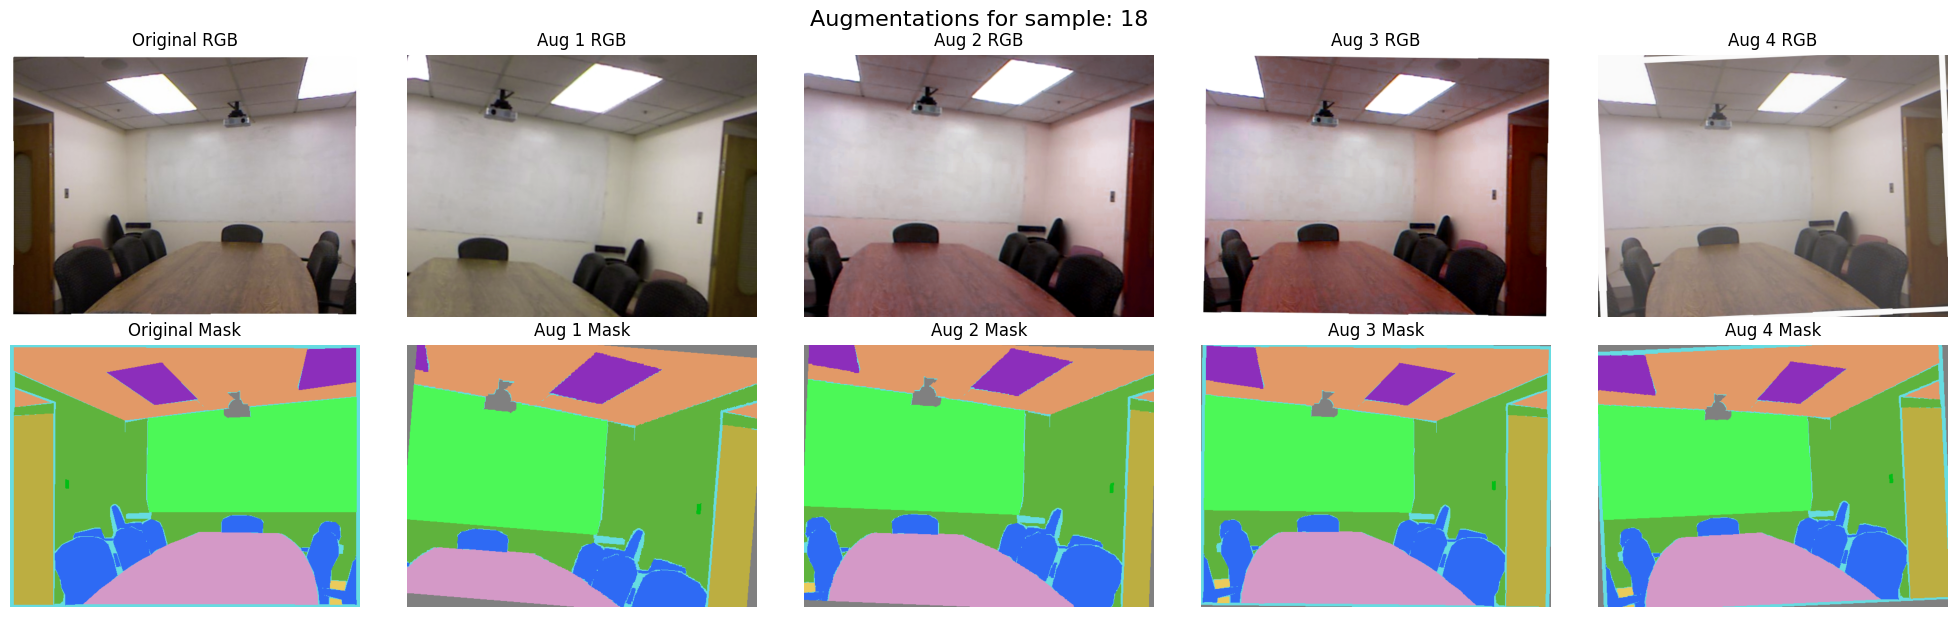

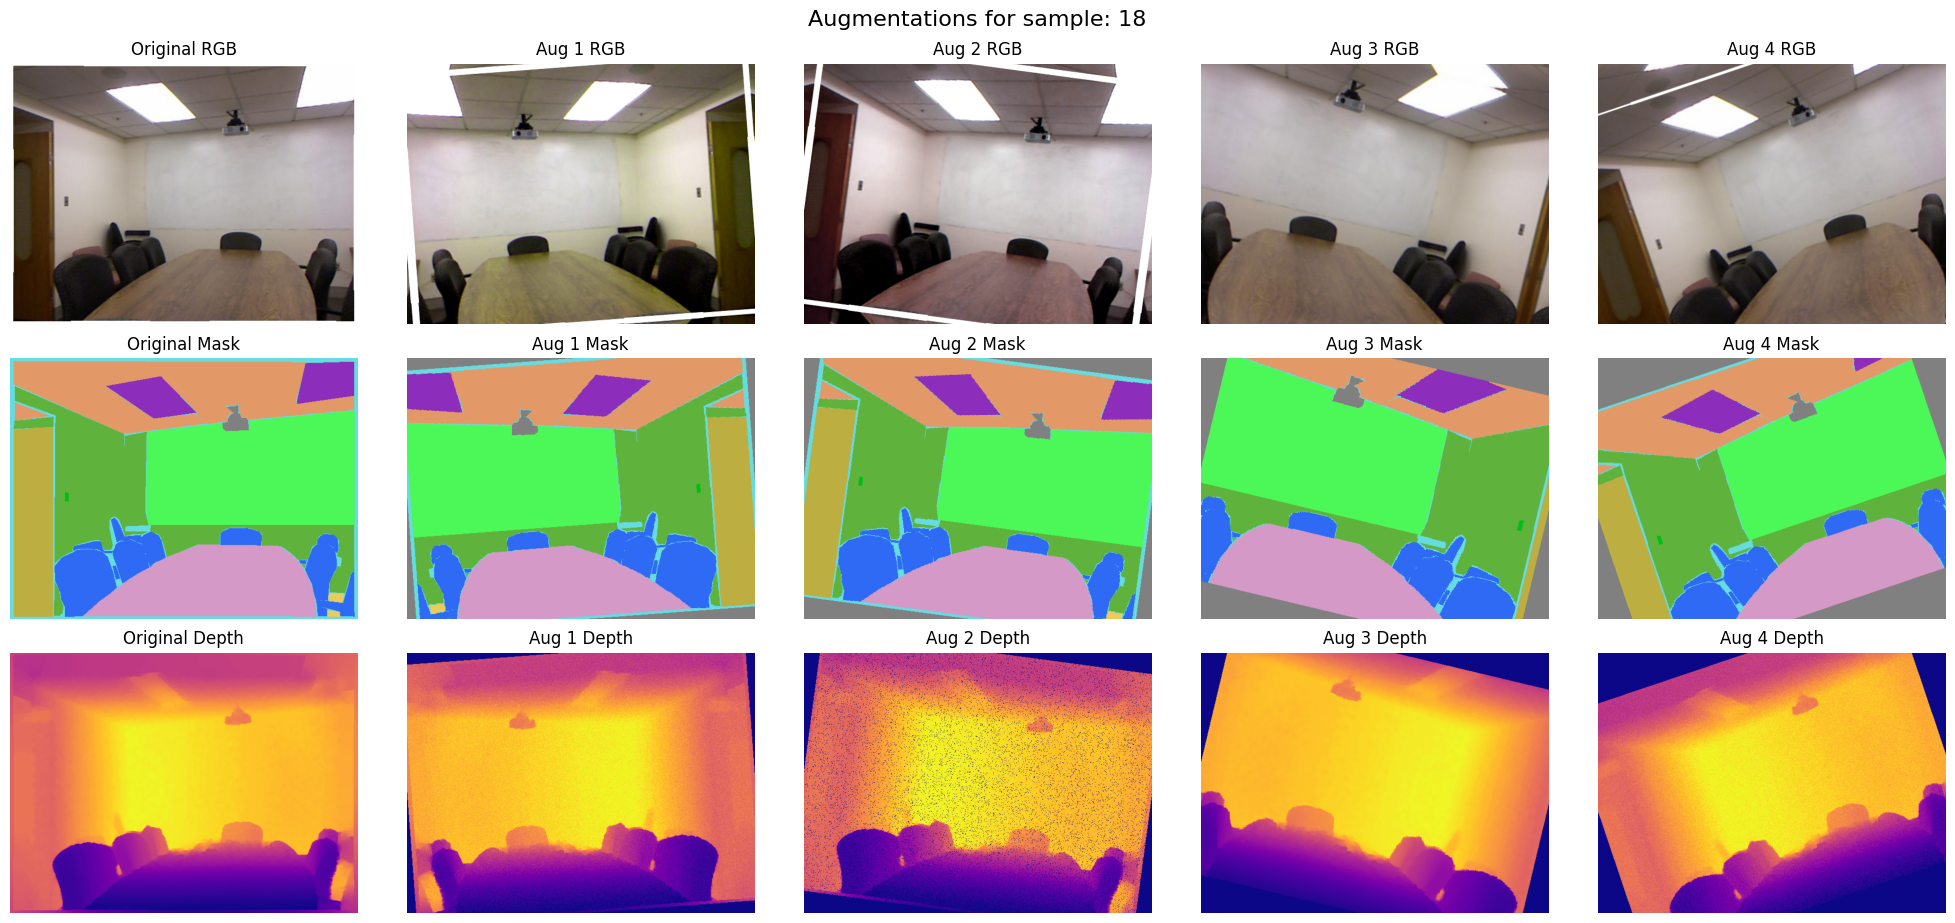

In [25]:
train_dataset = NYUDepthDataset(
    DATA_ROOT, "train", 
    processor=SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
)
show_augmentations(train_dataset, sample_idx=10, num_augmentations=4, use_depth=False)
show_augmentations(train_dataset, sample_idx=10, num_augmentations=4, use_depth=True)

---
# 📊 Section 3: Universal Trainer Class

A single, model-agnostic trainer that works with any PyTorch model and data loaders.

📏 Using processor size: {'height': 512, 'width': 512}
📊 Train: 636 samples,  Val: 159 samples,  Test: 654 samples
📦 Train batches: 80,  Val batches: 20,  Test batches: 82
\n🧪 Testing data loading...
✅ Batch loaded successfully!
📏 pixel_values shape: torch.Size([8, 3, 512, 512])
📏 labels shape: torch.Size([8, 512, 512])
🏷️ Sample IDs: ['598', '323', '260']


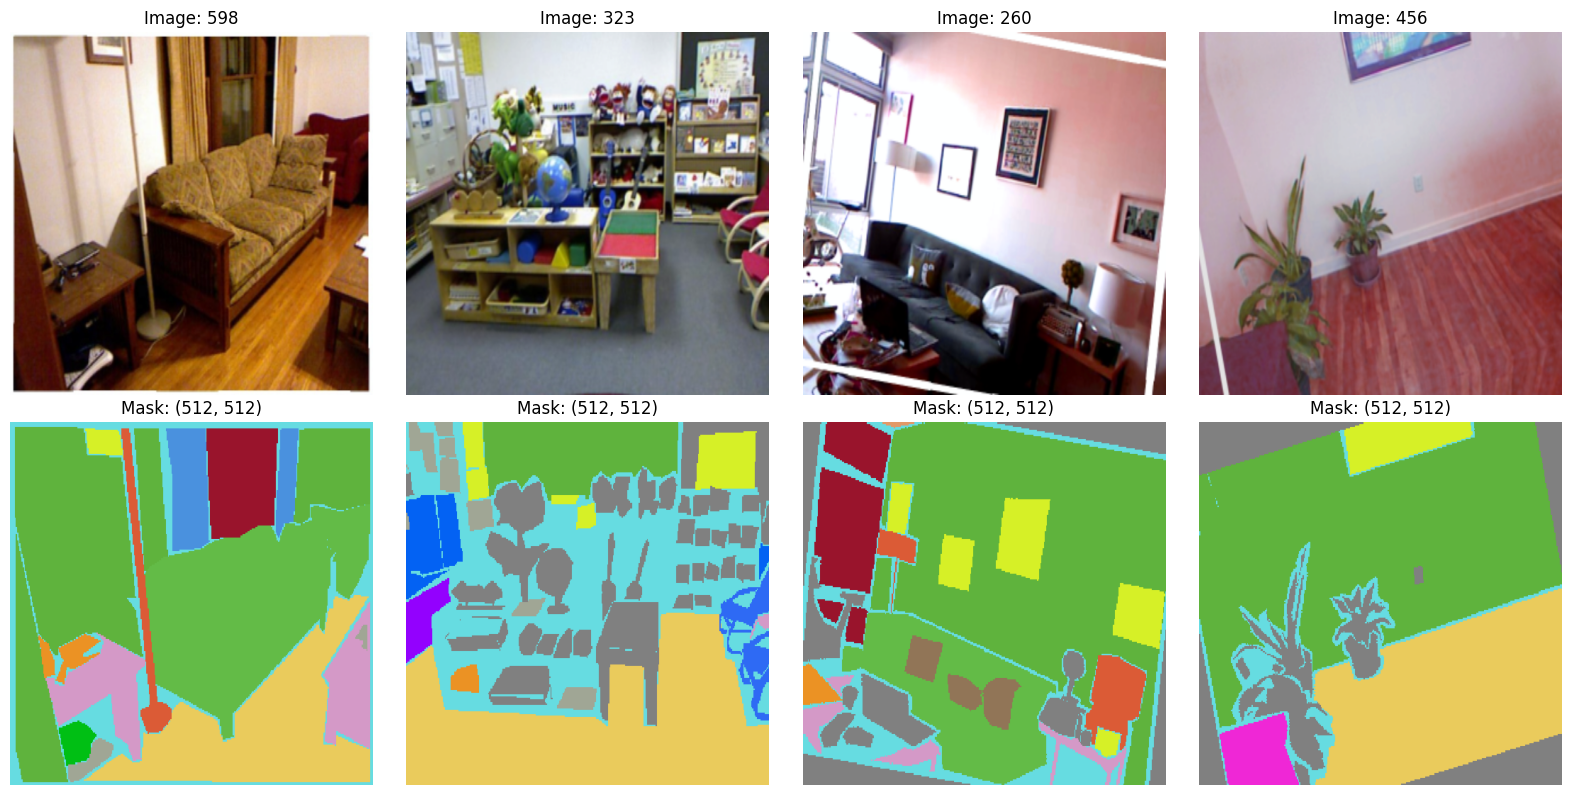

In [26]:
# Example: Data exploration and visualization using standalone function
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
processor = SegformerImageProcessor.from_pretrained(model_name)

# Create data loaders for exploration
train_loader, val_loader, test_loader = create_data_loaders(
    data_root=DATA_ROOT,
    processor=processor,
    batch_size=8,
    image_size=(240, 320),
    num_workers=0,
    pin_memory=True
)

# Test data loading and visualization
print("\\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
print(f"✅ Batch loaded successfully!")
print(f"📏 pixel_values shape: {sample_batch['pixel_values'].shape}")
print(f"📏 labels shape: {sample_batch['labels'].shape}")
print(f"🏷️ Sample IDs: {sample_batch['id'][:3]}")

# Visualize samples
visualize_batch(sample_batch, processor, num_samples=4)

In [ ]:
class Trainer:
    """Universal trainer class with automatic checkpoint resume."""
    
    def __init__(self, config: TrainingConfig):
        """
        Initialize trainer with configuration.
        
        Args:
            config: Training configuration with data and model setup
        """
        self.config = config
        self.device = self._setup_device()
        self.history = TrainingHistory()
        
        # Set random seeds for reproducibility
        self._set_random_seeds()
        
        # Create data loaders from config
        self.train_loader, self.val_loader, self.test_loader = self._create_data_loaders()
        
        # Auto-resume setup
        self.latest_checkpoint_path = self.config.model_dir / "latest.pth"
        self.start_epoch = 1
        self.loaded_checkpoint = None
        
        # Check for existing checkpoint
        if self.latest_checkpoint_path.exists():
            self._load_latest_checkpoint()
    
    def _setup_device(self) -> torch.device:
        """Setup training device."""
        if self.config.device == "auto":
            if torch.cuda.is_available():
                device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                device = torch.device("cpu")  # Temporary fix for MPS issues
            else:
                device = torch.device("cpu")
        else:
            device = torch.device(self.config.device)
        print(f"Using device: {device}")
        return device
    
    def _set_random_seeds(self) -> None:
        """Set random seeds for reproducible results."""
        random.seed(self.config.seed)
        np.random.seed(self.config.seed)
        torch.manual_seed(self.config.seed)
        torch.cuda.manual_seed_all(self.config.seed)
        
        # Make CuDNN deterministic (slower but reproducible)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        print(f"🎲 Random seeds set to {self.config.seed} for reproducibility")
    
    def _create_data_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        """Create training, validation, and test data loaders from config."""
        
        # Handle processor-based datasets (like SegFormer)
        if self.config.processor is not None:
            # Use the standalone create_data_loaders function
            return create_data_loaders(
                data_root=self.config.data_root,
                processor=self.config.processor,
                batch_size=self.config.batch_size,
                image_size=self.config.image_size,
                num_workers=self.config.num_workers,
                pin_memory=self.config.pin_memory
            )
        else:
            # For custom datasets without processor, you would implement your own dataset creation here
            # This is a placeholder for when processor=None
            raise NotImplementedError(
                "Custom dataset creation (processor=None) not implemented yet. "
                "Please provide a processor or implement custom dataset logic."
            )
    
    def _load_latest_checkpoint(self):
        """Load latest checkpoint and prepare for resume."""
        print(f"📂 Found checkpoint: {self.latest_checkpoint_path}")
        try:
            self.loaded_checkpoint = torch.load(self.latest_checkpoint_path, map_location='cpu', weights_only=False)
            self.start_epoch = self.loaded_checkpoint.get('epoch', 0) + 1
            
            # Load history if available
            if 'history' in self.loaded_checkpoint:
                history_dict = self.loaded_checkpoint['history']
                # Reconstruct TrainingHistory from dict
                self.history = TrainingHistory()
                for key, value in history_dict.items():
                    if hasattr(self.history, key):
                        setattr(self.history, key, value)
            
            print(f"✅ Will resume from epoch {self.start_epoch}")
            print(f"📈 Loaded {len(self.history)} epochs of training history")
            
        except Exception as e:
            print(f"❌ Failed to load checkpoint: {e}")
            print("🆕 Starting fresh training")
            self.loaded_checkpoint = None
            self.start_epoch = 1
    
    def _save_latest_checkpoint(self, model, optimizer, scaler, scheduler, epoch, metrics):
        """Save latest checkpoint (every epoch)."""
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "history": self.history.__dict__,
            "config": self.config,
            "metrics": metrics,
            "timestamp": datetime.now().isoformat()
        }
        
        torch.save(checkpoint, self.latest_checkpoint_path)
    
    def _save_best_model(self, model, optimizer, scheduler, epoch, metrics, best_miou):
        """Save best model checkpoint."""
        best_checkpoint_path = self.config.model_dir / "best.pth"
        best_checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
        
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "config": self.config,
            "metrics": metrics,
            "history": self.history,
            "best_miou": best_miou
        }
        
        torch.save(checkpoint, best_checkpoint_path)
        print(f"✅ Saved best model to {best_checkpoint_path} (mIoU: {best_miou:.4f})")
    
    @torch.no_grad()
    def evaluate(self, model, loader=None, criterion=None):
        """
        Evaluate model on validation data.
        
        Args:
            model: Model to evaluate
            loader: DataLoader to use (defaults to self.val_loader)
            criterion: Loss function to use for validation loss calculation
            
        Returns:
            Dictionary with evaluation metrics including loss if criterion provided
        """
        model.eval()
        loader = loader or self.val_loader
        
        cm = np.zeros((self.config.num_classes, self.config.num_classes), dtype=np.int64)
        total, correct = 0, 0
        running_val_loss = 0.0
        num_batches = 0
        
        for batch in loader:
            pixel_values = batch["pixel_values"].to(self.device, non_blocking=True)
            targets = batch["labels"].to(self.device, non_blocking=True)
            
            # Forward pass with mixed precision
            with autocast(device_type=self.device.type, enabled=(self.device.type == "cuda")):
                outputs = model(pixel_values)
                
                # Handle different model output formats
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits  # SegFormer format
                else:
                    logits = outputs  # Standard tensor output
                
                # Upsample logits to target size if needed
                if logits.shape[-2:] != targets.shape[-2:]:
                    logits = torch.nn.functional.interpolate(
                        logits, size=targets.shape[-2:], mode="bilinear", align_corners=False
                    )
                
                # Calculate validation loss if criterion provided
                if criterion is not None:
                    val_loss = criterion(logits, targets)
                    running_val_loss += val_loss.item()
                    num_batches += 1
            
            pred = logits.argmax(1)  # [B,H,W]
            
            valid = targets != self.config.ignore_index
            total += valid.sum().item()
            correct += (pred[valid] == targets[valid]).sum().item()
            
            p = pred[valid].view(-1).cpu().numpy()
            t = targets[valid].view(-1).cpu().numpy()
            for i in range(p.shape[0]):
                if 0 <= t[i] < self.config.num_classes and 0 <= p[i] < self.config.num_classes:
                    cm[t[i], p[i]] += 1
        
        # Calculate metrics
        inter = np.diag(cm).astype(np.float64)
        gt = cm.sum(1).astype(np.float64)
        pr = cm.sum(0).astype(np.float64)
        union = gt + pr - inter
        iou = inter / np.maximum(union, 1)
        miou = float(np.nanmean(iou)) if iou.size > 0 else 0.0
        pixacc = float(correct / max(total, 1))
        
        metrics = {"mIoU": miou, "PixelAcc": pixacc, "IoU_per_class": iou}
        
        # Add validation loss if calculated
        if criterion is not None and num_batches > 0:
            avg_val_loss = running_val_loss / num_batches
            metrics["loss"] = avg_val_loss
        
        return metrics
    
    def train(self, model, optimizer=None, scheduler=None, criterion=None,
              gradient_clip_val=1.0, early_stopping_patience=None):
        """
        Train the provided model with automatic checkpoint resume.

        Args:
            model: PyTorch model to train
            optimizer: Custom optimizer (defaults to AdamW)
            scheduler: Custom scheduler (defaults to None)
            criterion: Custom loss function (defaults to CrossEntropyLoss)
            gradient_clip_val: Gradient clipping value (None to disable)
            early_stopping_patience: Stop training if no improvement for N epochs (None to disable)

        Returns:
            Trained model
        """
        # Prepare model
        model = model.to(self.device)
        
        # Setup training components with defaults if not provided
        if criterion is None:
            criterion = nn.CrossEntropyLoss(ignore_index=self.config.ignore_index)
            
        if optimizer is None:
            optimizer = optim.AdamW(
                model.parameters(), lr=self.config.learning_rate
            )
            print(f"📊 Using default AdamW optimizer (LR: {self.config.learning_rate:.2e})")
        else:
            print(f"📊 Using custom optimizer: {type(optimizer).__name__}")
            
        scaler = GradScaler(enabled=(self.device.type == "cuda"))
        
        if scheduler:
            print(f"📈 Using custom scheduler: {type(scheduler).__name__}")
        else:
            print("📈 No LR scheduling (constant learning rate)")
        
        # Early stopping setup
        if early_stopping_patience is not None:
            print(f"🛑 Early stopping enabled (patience: {early_stopping_patience} epochs)")
            best_miou_for_early_stop = -1.0
            patience_counter = 0
            min_delta = 0.001  # Minimum improvement threshold
        
        # Load checkpoint states if resuming
        if self.loaded_checkpoint:
            print("🔄 Restoring training state from checkpoint...")
            
            # Load model state
            model.load_state_dict(self.loaded_checkpoint['model_state_dict'])
            
            # Load optimizer state
            if 'optimizer_state_dict' in self.loaded_checkpoint:
                optimizer.load_state_dict(self.loaded_checkpoint['optimizer_state_dict'])
            
            # Load scheduler state
            if scheduler and 'scheduler_state_dict' in self.loaded_checkpoint and self.loaded_checkpoint['scheduler_state_dict']:
                scheduler.load_state_dict(self.loaded_checkpoint['scheduler_state_dict'])
            
            # Load scaler state
            if 'scaler_state_dict' in self.loaded_checkpoint:
                scaler.load_state_dict(self.loaded_checkpoint['scaler_state_dict'])
            
            print("✅ Training state restored")
        
        # Print parameter information
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        if gradient_clip_val is not None:
            print(f"✂️ Gradient clipping enabled (max_norm: {gradient_clip_val})")
        
        # Training setup
        best_miou = max(self.history.val_miou) if self.history.val_miou else -1.0
        
        print(f"🚀 Starting training for {self.config.epochs} epochs...")
        print(f"📊 Training batches: {len(self.train_loader)}, Validation batches: {len(self.val_loader)}")
        print(f"▶️ Resuming from epoch {self.start_epoch}")
        
        for epoch in range(self.start_epoch, self.config.epochs + 1):
            model.train()
            running_loss = 0.0
            epoch_start = time.time()
            
            print(f"n📈 Epoch {epoch}/{self.config.epochs}")
            
            for it, batch in enumerate(self.train_loader, start=1):
                pixel_values = batch["pixel_values"].to(self.device, non_blocking=True)
                targets = batch["labels"].to(self.device, non_blocking=True)
                
                optimizer.zero_grad(set_to_none=True)
                
                # Forward pass with mixed precision
                with autocast(device_type=self.device.type, enabled=(self.device.type == "cuda")):
                    outputs = model(pixel_values)
                    
                    # Handle different model output formats
                    if hasattr(outputs, 'logits'):
                        logits = outputs.logits  # SegFormer format
                    else:
                        logits = outputs  # Standard tensor output
                    
                    # Upsample logits to target size if needed
                    if logits.shape[-2:] != targets.shape[-2:]:
                        logits = torch.nn.functional.interpolate(
                            logits, size=targets.shape[-2:], mode="bilinear", align_corners=False
                        )
                    
                    loss = criterion(logits, targets)
                
                # Backward pass
                scaler.scale(loss).backward()
                
                # Gradient clipping
                if gradient_clip_val is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                
                scaler.step(optimizer)
                scaler.update()
                
                running_loss += loss.item()
                
                # Log periodically
                if it % self.config.log_every == 0:
                    avg_loss = running_loss / it
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"   Batch {it:05d}/{len(self.train_loader)} | Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")
            
            # Step scheduler if provided
            if scheduler is not None:
                scheduler.step()
            
            # Validation
            print("🔍 Running validation...")
            val_metrics = self.evaluate(model, criterion=criterion)
            current_miou = val_metrics["mIoU"]
            
            # Early stopping check
            if early_stopping_patience is not None:
                if current_miou > best_miou_for_early_stop + min_delta:
                    best_miou_for_early_stop = current_miou
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                print(f"📊 Early stopping: {patience_counter}/{early_stopping_patience} (best: {best_miou_for_early_stop:.4f})")
                
                if patience_counter >= early_stopping_patience:
                    print(f"🛑 Early stopping triggered at epoch {epoch}")
                    print(f"   No improvement in validation mIoU for {early_stopping_patience} epochs")
                    break
            
            # Calculate epoch metrics
            epoch_time = time.time() - epoch_start
            avg_train_loss = running_loss / len(self.train_loader)
            current_lr = optimizer.param_groups[0]['lr']
            
            # Add to history
            self.history.add_epoch({
                "train_loss": avg_train_loss,
                "train_miou": 0.0,  # Not calculated during training for performance
                "train_pixacc": 0.0,  # Not calculated during training for performance
                "val_loss": val_metrics.get("loss", 0.0),
                "val_miou": val_metrics["mIoU"],
                "val_pixacc": val_metrics["PixelAcc"],
                "val_iou_per_class": val_metrics["IoU_per_class"].tolist(),
                "learning_rate": current_lr,
                "epoch_time": epoch_time
            })
            
            # Print epoch summary
            print(f"\\n📊 Epoch {epoch} Results:")
            print(f"   • Train Loss: {avg_train_loss:.4f}")
            if "loss" in val_metrics:
                print(f"   • Val Loss: {val_metrics['loss']:.4f}")
            print(f"   • Val mIoU: {val_metrics['mIoU']:.4f}")
            print(f"   • Val PixelAcc: {val_metrics['PixelAcc']:.4f}")
            print(f"   • Epoch Time: {epoch_time:.1f}s")
            print(f"   • Learning Rate: {current_lr:.2e}")
            
            # Save best model
            if val_metrics["mIoU"] > best_miou:
                best_miou = val_metrics["mIoU"]
                self._save_best_model(model, optimizer, scheduler, epoch, val_metrics, best_miou)
            
            # Save latest checkpoint every epoch
            self._save_latest_checkpoint(model, optimizer, scaler, scheduler, epoch, val_metrics)
            
            # Save every 5 epochs 
            if epoch % 5 == 0:
                epoch_checkpoint_path = self.config.model_dir / f"checkpoint_epoch_{epoch}.pth"
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
                    "scaler_state_dict": scaler.state_dict(),
                    "history": self.history.__dict__,
                    "config": self.config,
                    "metrics": val_metrics,
                    "timestamp": datetime.now().isoformat()
                }, epoch_checkpoint_path)
                print(f"💾 Saved periodic checkpoint to {epoch_checkpoint_path}")

            print("-" * 80)
        
        print(f"\\n🎉 Training Complete!")
        print(f"   • Best Validation mIoU: {best_miou:.4f}")
        print(f"   • Total Training Time: {sum(self.history.epoch_times):.1f}s")
        
        return model

print("✅ Simplified Trainer class with early stopping defined!")

✅ Simplified Trainer class with early stopping defined!


In [8]:
def print_model_status(model):
    """Show which parts of the model are frozen/unfrozen."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    
    print(f"📊 Model status: {trainable_params:,} trainable / {total_params:,} total")
    print(f"   ({frozen_params:,} frozen parameters)")


In [29]:
segformer_training_config = TrainingConfig(
    data_root=DATA_ROOT,
    epochs=300,
    batch_size=32,
    learning_rate=1e-4,  # Conservative learning rate
    model_name="segformer_b0",
    processor=SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
)

# Create fresh SegFormer model
segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=40,
    ignore_mismatched_sizes=True
)

# freeze all encoder layers
for param in segformer_model.segformer.encoder.parameters():
    param.requires_grad = False

print_model_status(segformer_model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([40]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([40, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model status: 405,032 trainable / 3,724,424 total
   (3,319,392 frozen parameters)


In [30]:
def plot_training_history(history: TrainingHistory):
    """Plot training and validation loss and mIoU over epochs."""
    epochs = range(1, len(history) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    ax1.plot(epochs, history.train_loss, label='Train Loss', color='blue')
    ax1.plot(epochs, history.val_loss, label='Val Loss', color='orange')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot mIoU
    ax2.plot(epochs, history.val_miou, label='Val mIoU', color='green')
    ax2.plot(epochs,history.val_pixacc, label='Val PixelAcc', color='red')
    ax2.set_title('Validation mIoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('mIoU')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# create cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optim.AdamW(segformer_model.parameters(), lr=segformer_training_config.learning_rate),
    T_max=segformer_training_config.epochs
)

trainer = Trainer(segformer_training_config)
trained_model = trainer.train(segformer_model, scheduler=scheduler, early_stopping_patience=5)

plot_training_history(trainer.history)

Using device: cpu
🎲 Random seeds set to 42 for reproducibility
📏 Using processor size: {'height': 512, 'width': 512}
📊 Train: 636 samples,  Val: 159 samples,  Test: 654 samples
📦 Train batches: 20,  Val batches: 5,  Test batches: 21
📊 Using default AdamW optimizer (LR: 1.00e-04)
📈 Using custom scheduler: CosineAnnealingLR
🛑 Early stopping enabled (patience: 5 epochs)
Total parameters: 3,724,424
Trainable parameters: 405,032
✂️ Gradient clipping enabled (max_norm: 1.0)
🚀 Starting training for 300 epochs...
📊 Training batches: 20, Validation batches: 5
▶️ Resuming from epoch 1
n📈 Epoch 1/300
   Batch 00001/20 | Loss: 3.8322 | LR: 1.00e-04
   Batch 00002/20 | Loss: 3.8144 | LR: 1.00e-04
   Batch 00003/20 | Loss: 3.7982 | LR: 1.00e-04
   Batch 00004/20 | Loss: 3.7920 | LR: 1.00e-04
   Batch 00005/20 | Loss: 3.7849 | LR: 1.00e-04
   Batch 00006/20 | Loss: 3.7801 | LR: 1.00e-04
   Batch 00007/20 | Loss: 3.7761 | LR: 1.00e-04
   Batch 00008/20 | Loss: 3.7705 | LR: 1.00e-04
   Batch 00009/20 |

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights # fcn_resnet50, FCN_ResNet50_Weights

dl_rn50_training_config = TrainingConfig(
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    model_name="deeplabv3_resnet50",
    processor=DeepLabV3_ResNet50_Weights.DEFAULT.transforms()
)

model_dl_rn50 = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

# Modify the final layer to match NYU40 classes
model_dl_rn50.classifier[-1] = nn.Conv2d(256, 40, kernel_size=(1, 1), stride=(1, 1))  # 40 classes for NYU40

print("Layers in the classifier:")
for i, layer in enumerate(model_dl_rn50.classifier):
    print(f"Layer {i}: {type(layer).__name__}")


Layers in the classifier:
Layer 0: ASPP
Layer 1: Conv2d
Layer 2: BatchNorm2d
Layer 3: ReLU
Layer 4: Conv2d


In [ ]:
# Freeze all parameters
for param in model_dl_rn50.parameters():
    param.requires_grad = False
    
# Phase 1: train only classifier head
print("Unfreezing classifier: final classifier layer")
for param in model_dl_rn50.classifier[-1].parameters():
    param.requires_grad = True
print_model_status(model_dl_rn50)

# trainer = Trainer(dl_rn50_training_config)

# Phase 2: Unfreeze ASPP and classifier head
print("Unfreezing classifier: ASPP and classifier head")
for param in model_dl_rn50.classifier[0].parameters():
    param.requires_grad = True
print_model_status(model_dl_rn50)

# Phase 3: Unfreeze Conv block
print("Unfreezing classifier: Conv block, ASPP, and classifier head")
for param in model_dl_rn50.classifier[1].parameters():
    param.requires_grad = True
print_model_status(model_dl_rn50)

# Phase 4: All encoder unfrozen (ie unfreeze BN layer only)
print("Unfreezing classifier: Conv block, ASPP, and classifier head all classifier layers")
for param in model_dl_rn50.classifier.parameters():
    param.requires_grad = True
print_model_status(model_dl_rn50)

# Phase 4: All encoder unfrozen (ie unfreeze BN layer only)
print("Unfreezing classifier: all classifier layers unfrozen")
for param in model_dl_rn50.classifier.parameters():
    param.requires_grad = True
print_model_status(model_dl_rn50)

Unfreezing classifier: final classifier layer
📊 Model status: 10,280 trainable / 42,008,957 total
   (41,998,677 frozen parameters)
Unfreezing classifier: ASPP and classifier head
📊 Model status: 15,545,384 trainable / 42,008,957 total
   (26,463,573 frozen parameters)
Unfreezing classifier: Conv block, ASPP, and classifier head
📊 Model status: 16,135,208 trainable / 42,008,957 total
   (25,873,749 frozen parameters)
Unfreezing all classifier layers
📊 Model status: 16,135,720 trainable / 42,008,957 total
   (25,873,237 frozen parameters)
